## Objectives

1) Track the impact of living conditions of students aged 15 to 22 on their performance in mathematics  
2) Prepare data for the model

## Import libraries and load dataset

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

df = pd.read_csv('stud_math.csv')

In [56]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Preprocessing dataset¶

In [58]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [59]:
df.rename(columns={'Pstatus': 'pstatus', 'Medu': 'medu', 'Fedu': 'fedu',
                   'Mjob': 'mjob', 'Fjob': 'fjob',
                   'studytime, granular': 'granular', }, inplace=True)

## Function definition

In [60]:
def categorical_check(col):
    '''Unique data counter output and basic statistics
    '''
    display(pd.DataFrame(df[col].value_counts()))
    display(df[col].describe())


def numerical_check(col):
    '''Histogram output and basic statistics
    '''
    display(df[col].hist())
    display(df[col].describe())


def fill_mode(col):
    '''Replacing missing values with mode
    '''
    df[col].fillna(df[col].mode()[0], inplace=True)


def fill_median(col):
    '''Replacing missing values with median
    '''
    df[col].fillna(df[col].median(), inplace=True)


def outliers(col):
    '''Plotting Outliers and Calculating Outlier Boundaries
    '''
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
    .hist(bins=16, range=(0, 100), label='values')
    df[col].loc[df[col] >= r_side].hist(alpha=0.5, bins=16, range=(0, 100),
                                        label='Data Outlier')
    plt.legend()


def get_corr(dataframe):
    '''Building a heatmap of correlated data
    '''
    df = dataframe
    plt.figure(figsize=(12, 10), dpi=300)
    sns.heatmap(df.corr(), xticklabels=df.corr().columns,
                yticklabels=df.corr().columns, cmap='RdYlGn',
                center=0, annot=True)
    plt.title('Correlation', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


def get_boxplot(col):
    '''Build boxplot
    '''
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.boxplot(x=col, y='score',
                data=df.loc[df.loc[:, col].isin(df.loc[:, col].value_counts()
                                                .index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()


def get_stat_dif(dataframe, col):
    '''Finding statistically important columns using Student's t test
    '''
    df = dataframe
    cols = df.loc[:, col].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, col] == comb[0], 'score'],
                     df.loc[df.loc[:, col] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Bonferroni amendment
            print('Found statistically differences for the column:', col)
            break


def bin_to_num(dataframe, col, bin1, bin2):
    '''Replacing binary values with numeric 1 or 0
    '''
    df = dataframe
    df[col] = df[col].apply(lambda x: 1 if x == bin1 else
                            0 if x == bin2 else None)

## Data Exploration

### school

In [61]:
categorical_check('school')

,school
GP,349
MS,46


count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

No zero data

### sex

In [62]:
categorical_check('sex')

,sex
F,208
M,187


count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

No zero data

### age

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

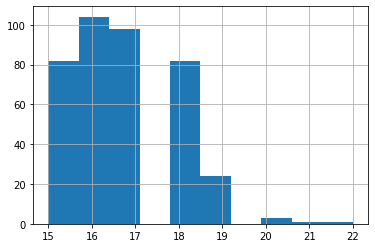

In [63]:
numerical_check('age')

No zero data

### address

In [64]:
categorical_check('address')

,address
U,295
R,83


count     378
unique      2
top         U
freq      295
Name: address, dtype: object

There are 17 data gaps, there is a pronounced mode, we will replace the gaps with mode

In [65]:
fill_mode('address')

### famsize

In [66]:
categorical_check('famsize')

,famsize
GT3,261
LE3,107


count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

There are 27 data gaps. Let's fill in the gaps in proportion to the sample 70/30, while giving the type of residence as a guideline, i.e. if the family lives in the house then the family size is more than 3

In [67]:
df.update(df[df.address == 'R'].famsize.fillna('GT3'))
df.famsize.fillna('GT3', limit = 12, inplace = True)
df.famsize.fillna('LE3', inplace = True)
categorical_check('famsize')

,famsize
GT3,280
LE3,115


count     395
unique      2
top       GT3
freq      280
Name: famsize, dtype: object

### pstatus

In [68]:
categorical_check('pstatus')

,pstatus
T,314
A,36


count     350
unique      2
top         T
freq      314
Name: pstatus, dtype: object

There are 45 data gaps. Fill in the gaps proportionally to the sample, while the data "live together" will be larger for those with a family size greater than 3

In [69]:
df.update(df[df.famsize == 'LE3'].pstatus.fillna('A', limit = 5))
df.pstatus.fillna('T', inplace = True)
categorical_check('pstatus')

,pstatus
T,354
A,41


count     395
unique      2
top         T
freq      354
Name: pstatus, dtype: object

### medu

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

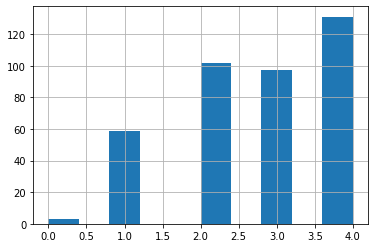

In [70]:
numerical_check('medu')

Missing 3 values, no outliers. Fill in the gaps with the median value

In [71]:
fill_median('medu')

### fedu

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

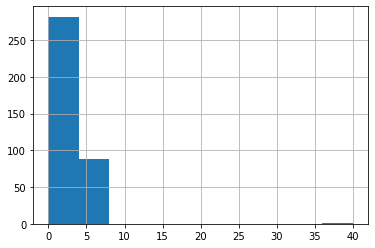

In [72]:
numerical_check('fedu')

There are 24 gaps and outliers are also observed (all values> 4). Most likely a mistake was made and an extra 0 was put, so we replace the value 40 with 4, and fill in the gaps with the median value

count    395.000000
mean       2.486076
std        1.062362
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

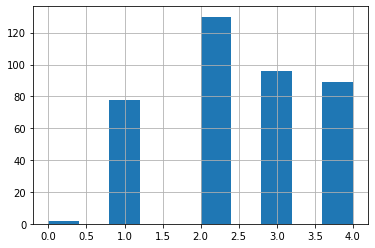

In [73]:
df.loc[df.fedu == 40, 'fedu'] = 4
fill_median('fedu')
numerical_check('fedu')

### mjob

In [74]:
categorical_check('mjob')

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


count       376
unique        5
top       other
freq        133
Name: mjob, dtype: object

There are 19 data gaps, replace with mode

In [75]:
fill_mode('mjob')
categorical_check('mjob')

,mjob
other,152
services,98
at_home,58
teacher,55
health,32


count       395
unique        5
top       other
freq        152
Name: mjob, dtype: object

### fjob

In [76]:
categorical_check('fjob')

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


count       359
unique        5
top       other
freq        197
Name: fjob, dtype: object

There are 36 data gaps, replace with mode

In [77]:
fill_mode('fjob')
categorical_check('fjob')

,fjob
other,233
services,102
teacher,29
at_home,16
health,15


count       395
unique        5
top       other
freq        233
Name: fjob, dtype: object

### reason

In [78]:
categorical_check('reason')

,reason
course,137
home,104
reputation,103
other,34


count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

There are 17 gaps, there is a weakly expressed mode, distribute the gaps in proportion to 3 values

In [79]:
df.reason.fillna('home', limit=5, inplace=True)
df.reason.fillna('reputation', limit=5, inplace=True)
df.reason.fillna('course', inplace=True)
categorical_check('reason')

,reason
course,144
home,109
reputation,108
other,34


count        395
unique         4
top       course
freq         144
Name: reason, dtype: object

### guardian

In [80]:
categorical_check('guardian')

,guardian
mother,250
father,86
other,28


count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

There are 31 gaps, while there is a pronounced mode, we will distribute the gaps proportionally

In [81]:
df.guardian.fillna('other', limit=2, inplace=True)
df.guardian.fillna('father', limit=7, inplace=True)
df.guardian.fillna('mother', inplace=True)
categorical_check('guardian')

,guardian
mother,272
father,93
other,30


count        395
unique         3
top       mother
freq         272
Name: guardian, dtype: object

### traveltime

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

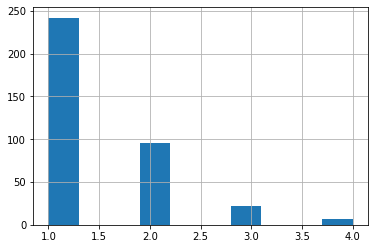

In [82]:
numerical_check('traveltime')

There are 28 gaps, no emissions, while there is a pronounced mode, we will distribute the gaps in proportion to the type of residence

count    395.000000
mean       1.407595
std        0.678490
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

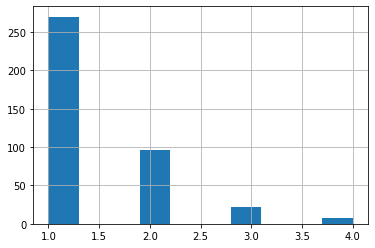

In [83]:
df.update(df[df.address == 'U'].traveltime.fillna(
    df.traveltime.mode()[0], limit=20))
fill_mode('traveltime')
numerical_check('traveltime')

### studytime

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

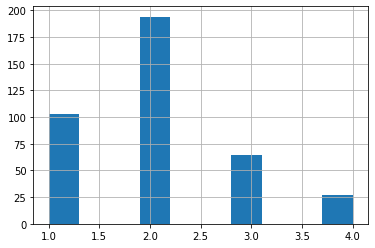

In [84]:
numerical_check('studytime')

There are 7 passes, no emissions. Replace the passes with mode.

count    395.000000
mean       2.037975
std        0.834580
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

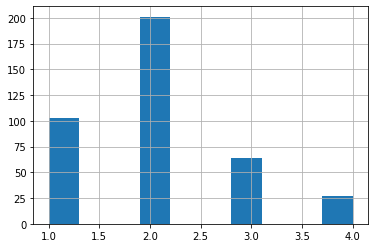

In [85]:
fill_mode('studytime')
numerical_check('studytime')

### failures

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

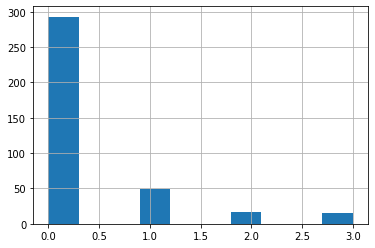

In [86]:
numerical_check('failures')

There are 22 passes, no emissions. Replace the passes with mode.

count    395.000000
mean       0.318987
std        0.726244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

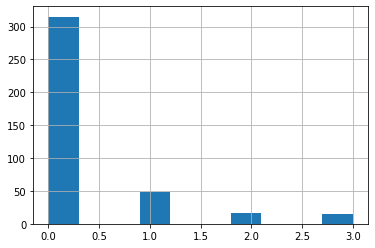

In [87]:
fill_mode('failures')
numerical_check('failures')

### schoolsup

In [88]:
categorical_check('schoolsup')

,schoolsup
no,335
yes,51


count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

There are 9 passes, in general, educational support does not depend on the reason for attending school, so let's fill the gaps with mode

In [89]:
fill_mode('schoolsup')
categorical_check('schoolsup')

,schoolsup
no,344
yes,51


count     395
unique      2
top        no
freq      344
Name: schoolsup, dtype: object

### famsup

In [90]:
categorical_check('famsup')

,famsup
yes,219
no,137


count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

There are 39 gaps, after a quick analysis of the reasons for the support, I settled on the fact that the gaps are primarily distributed among students whose parents are teachers

In [91]:
df.update(df[df.mjob == 'teacher'].famsup.fillna(df.famsup.mode()[0], limit=6))
df.update(df[df.fjob == 'teacher'].famsup.fillna(df.famsup.mode()[0], limit=4))
fill_mode('famsup')
categorical_check('famsup')

,famsup
yes,258
no,137


count     395
unique      2
top       yes
freq      258
Name: famsup, dtype: object

### paid

In [92]:
categorical_check('paid')

,paid
no,200
yes,155


count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

There are 40 omissions, I did not find any obvious dependencies, from interesting points, the ratio of who paid more was found among those whose mother works as a teacher, well, and parents in the health sector.
Let's fill in the gaps proportionally.

In [93]:
df.update(df[df.mjob == 'teacher'].paid.fillna('yes', limit=4))
df.update(df[df.famsup == 'yes'].paid.fillna('yes', limit=13))
fill_mode('paid')
categorical_check('paid')

,paid
no,223
yes,172


count     395
unique      2
top        no
freq      223
Name: paid, dtype: object

### activities

In [94]:
categorical_check('activities')

,activities
yes,195
no,186


count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

There are 14 absences, we will distribute proportionally, with the value "yes" preferably for those who spend more than 2 hours outside of school

In [95]:
df.update(df[df.studytime == 4].activities.fillna('yes'))
df.update(df[df.studytime == 3].activities.fillna('yes'))
df.update(df[df.studytime == 2].activities.fillna('yes'))
df.update(df[df.schoolsup == 'yes'].activities.fillna('yes'))
df.activities.fillna('no', inplace=True)
categorical_check('activities')

,activities
yes,204
no,191


count     395
unique      2
top       yes
freq      204
Name: activities, dtype: object

### nursery

In [96]:
categorical_check('nursery')

,nursery
yes,300
no,79


count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

There are 16 passes, and mostly those with a full family did not go to kindergarten. Distribute proportionally

In [97]:
df.update(df[df.pstatus == 'T'].nursery.fillna('yes', limit=13))
df.nursery.fillna('no', inplace=True)
categorical_check('nursery')

,nursery
yes,313
no,82


count     395
unique      2
top       yes
freq      313
Name: nursery, dtype: object

### granular

count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: granular, dtype: float64

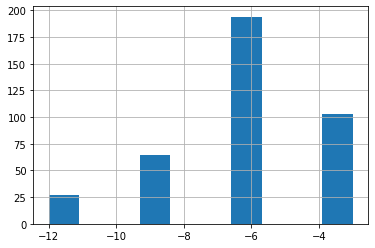

In [98]:
numerical_check('granular')

Based on the translation of the column name and values, it was not identified what this attribute was. Therefore, I will delete this column

In [99]:
df.drop('granular', axis=1, inplace=True)

### higher

In [100]:
categorical_check('higher')

,higher
yes,356
no,19


count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

There are 20 admissions, after the analysis of those who do not want to go to higher education, it turned out that the majority do not have school support, do not pay for additional courses in mathematics, and also devote less than 5 hours to extracurricular activities. First of all, fill in the blanks for similar students

In [101]:
df.update(df.query("schoolsup == 'no' & paid == 'no' & studytime <=2")
          .higher.fillna('no'))
fill_mode('higher')
categorical_check('higher')

,higher
yes,367
no,28


count     395
unique      2
top       yes
freq      367
Name: higher, dtype: object

### internet

In [102]:
categorical_check('internet')

,internet
yes,305
no,56


count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

There are 34 gaps, no obvious relationship was found, so we will distribute proportionally

In [103]:
df.update(df.query("school == 'GP' & guardian == 'mother' & paid == 'no'")
          .internet.fillna('no', limit=5))
fill_mode('internet')
categorical_check('internet')

,internet
yes,334
no,61


count     395
unique      2
top       yes
freq      334
Name: internet, dtype: object

### romantic

In [104]:
categorical_check('romantic')

,romantic
no,240
yes,124


count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

There are 31 gaps, a quick analysis showed that relationships are mainly among students over 17 years old and living in the city. Fill in the blanks

In [105]:
df.update(df.query("address == 'U' & age >= 17").romantic.fillna('yes', limit=11))
fill_mode('romantic')
categorical_check('romantic')

,romantic
no,262
yes,133


count     395
unique      2
top        no
freq      262
Name: romantic, dtype: object

### famrel

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

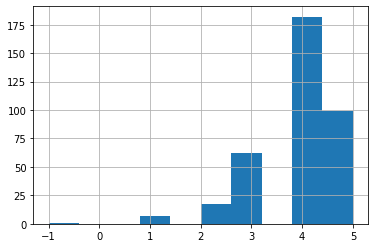

In [106]:
numerical_check('famrel')

There is one outlier (-1), but at the same time this student has family support, and the median and average are 4, then it can be assumed that initially there was a number 4, but during the recognition it was digitized as -1. There are 27 gaps, replace with the median

count    395.000000
mean       3.954430
std        0.859671
min        1.000000
25%        4.000000
50%        4.000000
75%        4.500000
max        5.000000
Name: famrel, dtype: float64

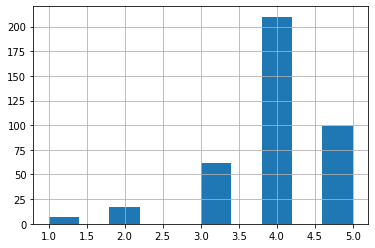

In [107]:
df.loc[df.famrel == -1, 'famrel'] = 4
fill_median('famrel')
numerical_check('famrel')

### freetime

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

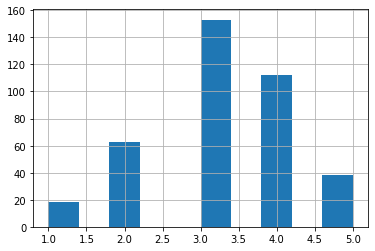

In [108]:
numerical_check('freetime')

There are no outliers, there are 11 gaps, replace with the median

count    395.000000
mean       3.225316
std        0.980711
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

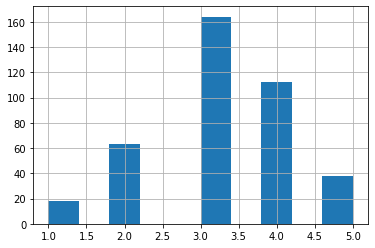

In [109]:
fill_median('freetime')
numerical_check('freetime')

### goout

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

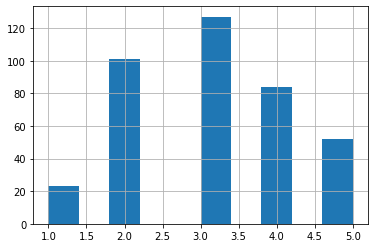

In [110]:
numerical_check('goout')

There are no outliers, there are 8 gaps, replace with the median

count    395.000000
mean       3.103797
std        1.104610
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

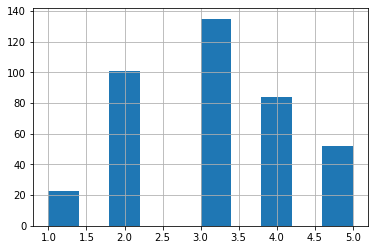

In [111]:
fill_median('goout')
numerical_check('goout')

### health

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

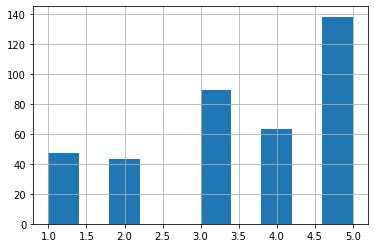

In [112]:
numerical_check('health')

There are 15 gaps, while the distribution is not normal, replace the gaps with the median

count    395.000000
mean       3.549367
std        1.372118
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

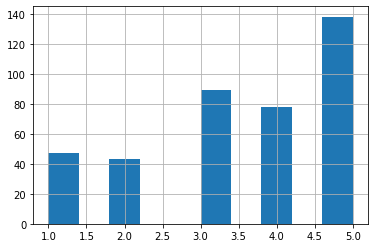

In [113]:
fill_median('health')
numerical_check('health')

### absences

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

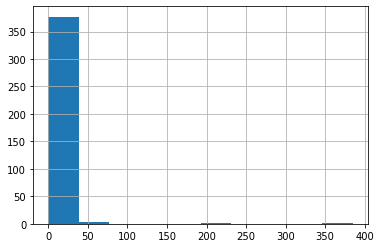

In [114]:
numerical_check('absences')

There are outliers and also there are 17 gaps

25 percentile: 0.0 
75 percentile: 8.0 
Data Outlier Boundaries: 
left: -12.0 
right: 20.0


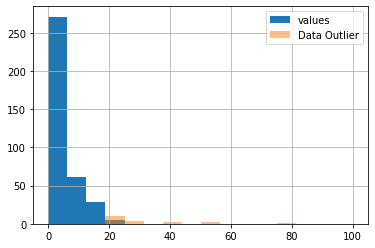

In [115]:
outliers('absences')

We will remove all outliers, and replace the gaps with mode

count    366.000000
mean       4.603825
std        4.965512
min        0.000000
25%        0.000000
50%        4.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

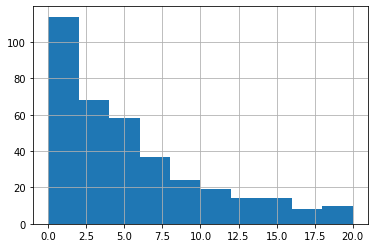

In [116]:
df = df.loc[df.absences <= 20]
fill_mode('absences')
numerical_check('absences')

### score

count    361.000000
mean      51.994460
std       22.956117
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

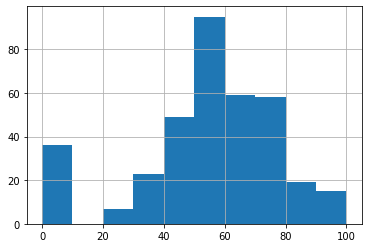

In [117]:
numerical_check('score')

25 percentile: 40.0 
75 percentile: 70.0 
Data Outlier Boundaries: 
left: -5.0 
right: 115.0


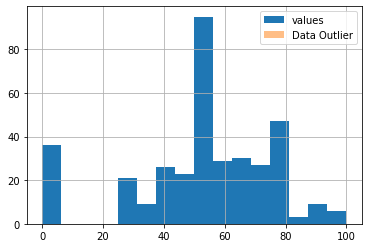

In [118]:
outliers('score')

Since this is the main criterion, we will remove all gaps. There are no outliers, but at the same time there is a large accumulation of data at 0, apparently these are students who did not pass the exam or did not come to it.

In [119]:
df.dropna(subset=['score'], inplace=True)

## Data analysis

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      361 non-null    object 
 1   sex         361 non-null    object 
 2   age         361 non-null    int64  
 3   address     361 non-null    object 
 4   famsize     361 non-null    object 
 5   pstatus     361 non-null    object 
 6   medu        361 non-null    float64
 7   fedu        361 non-null    float64
 8   mjob        361 non-null    object 
 9   fjob        361 non-null    object 
 10  reason      361 non-null    object 
 11  guardian    361 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   361 non-null    float64
 14  failures    361 non-null    float64
 15  schoolsup   361 non-null    object 
 16  famsup      361 non-null    object 
 17  paid        361 non-null    object 
 18  activities  361 non-null    object 
 19  nursery     361 non-null    o

### Correlation analysis

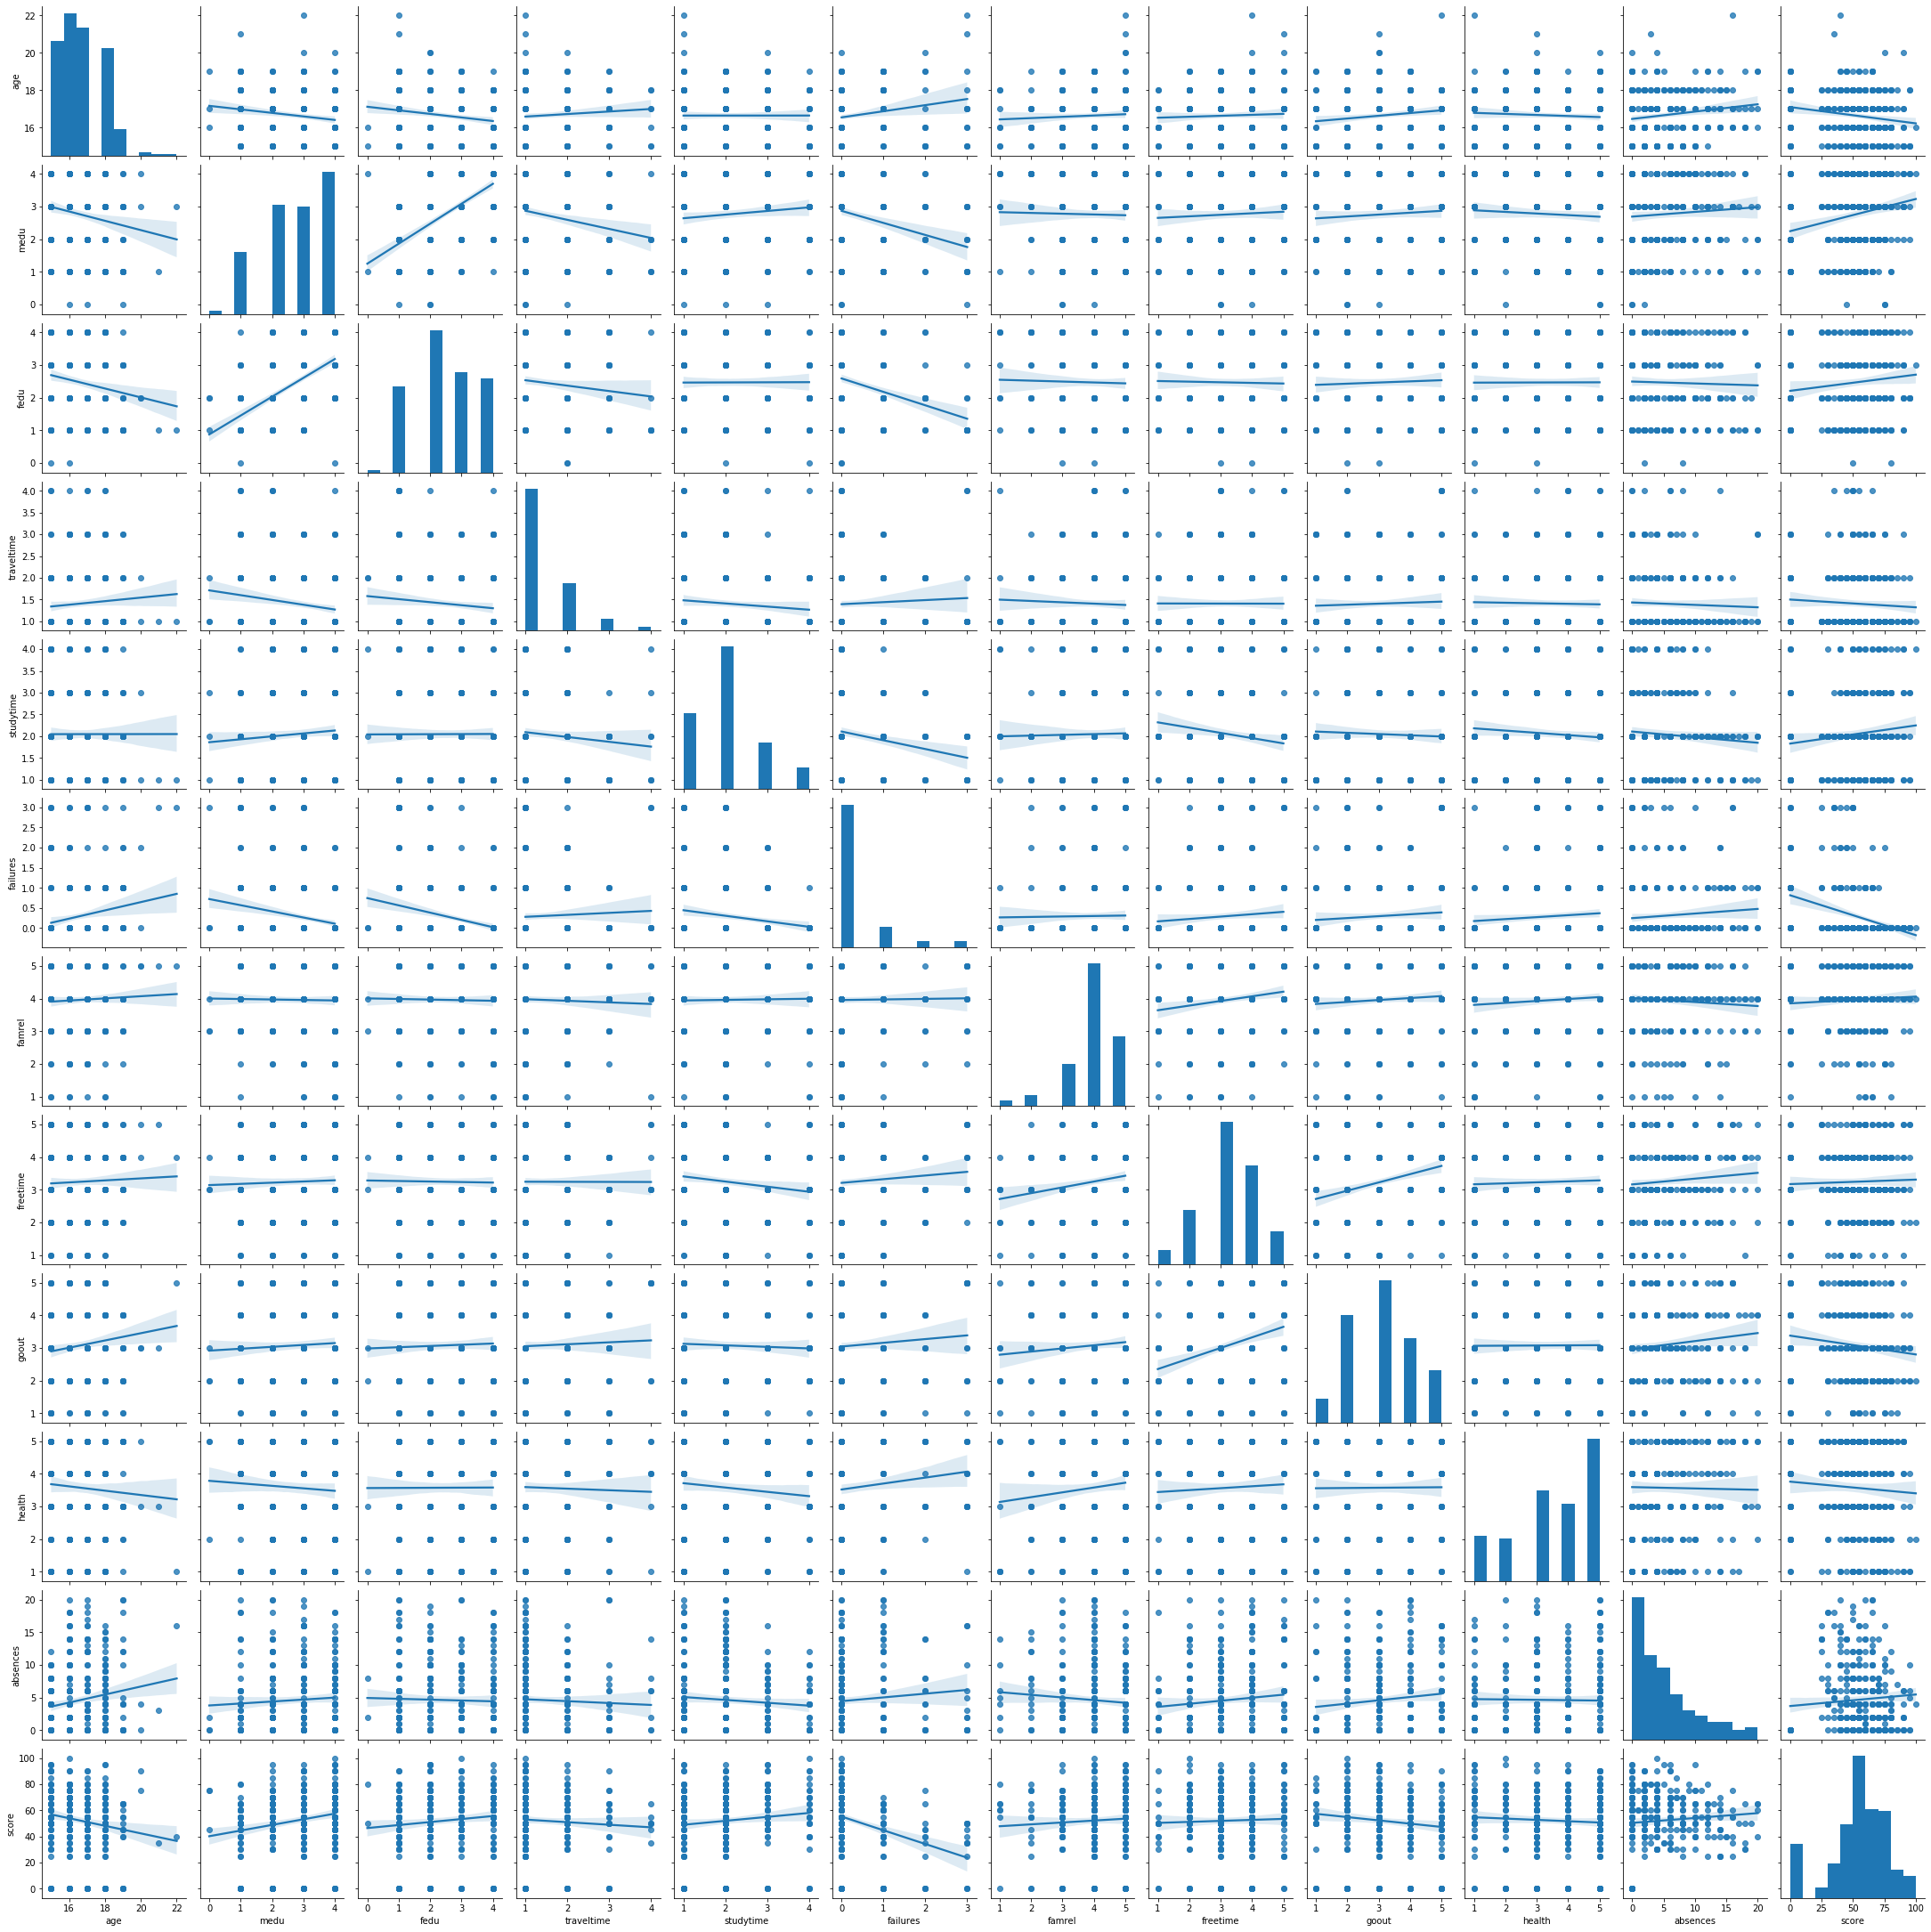

In [121]:
sns.pairplot(df, kind='reg')

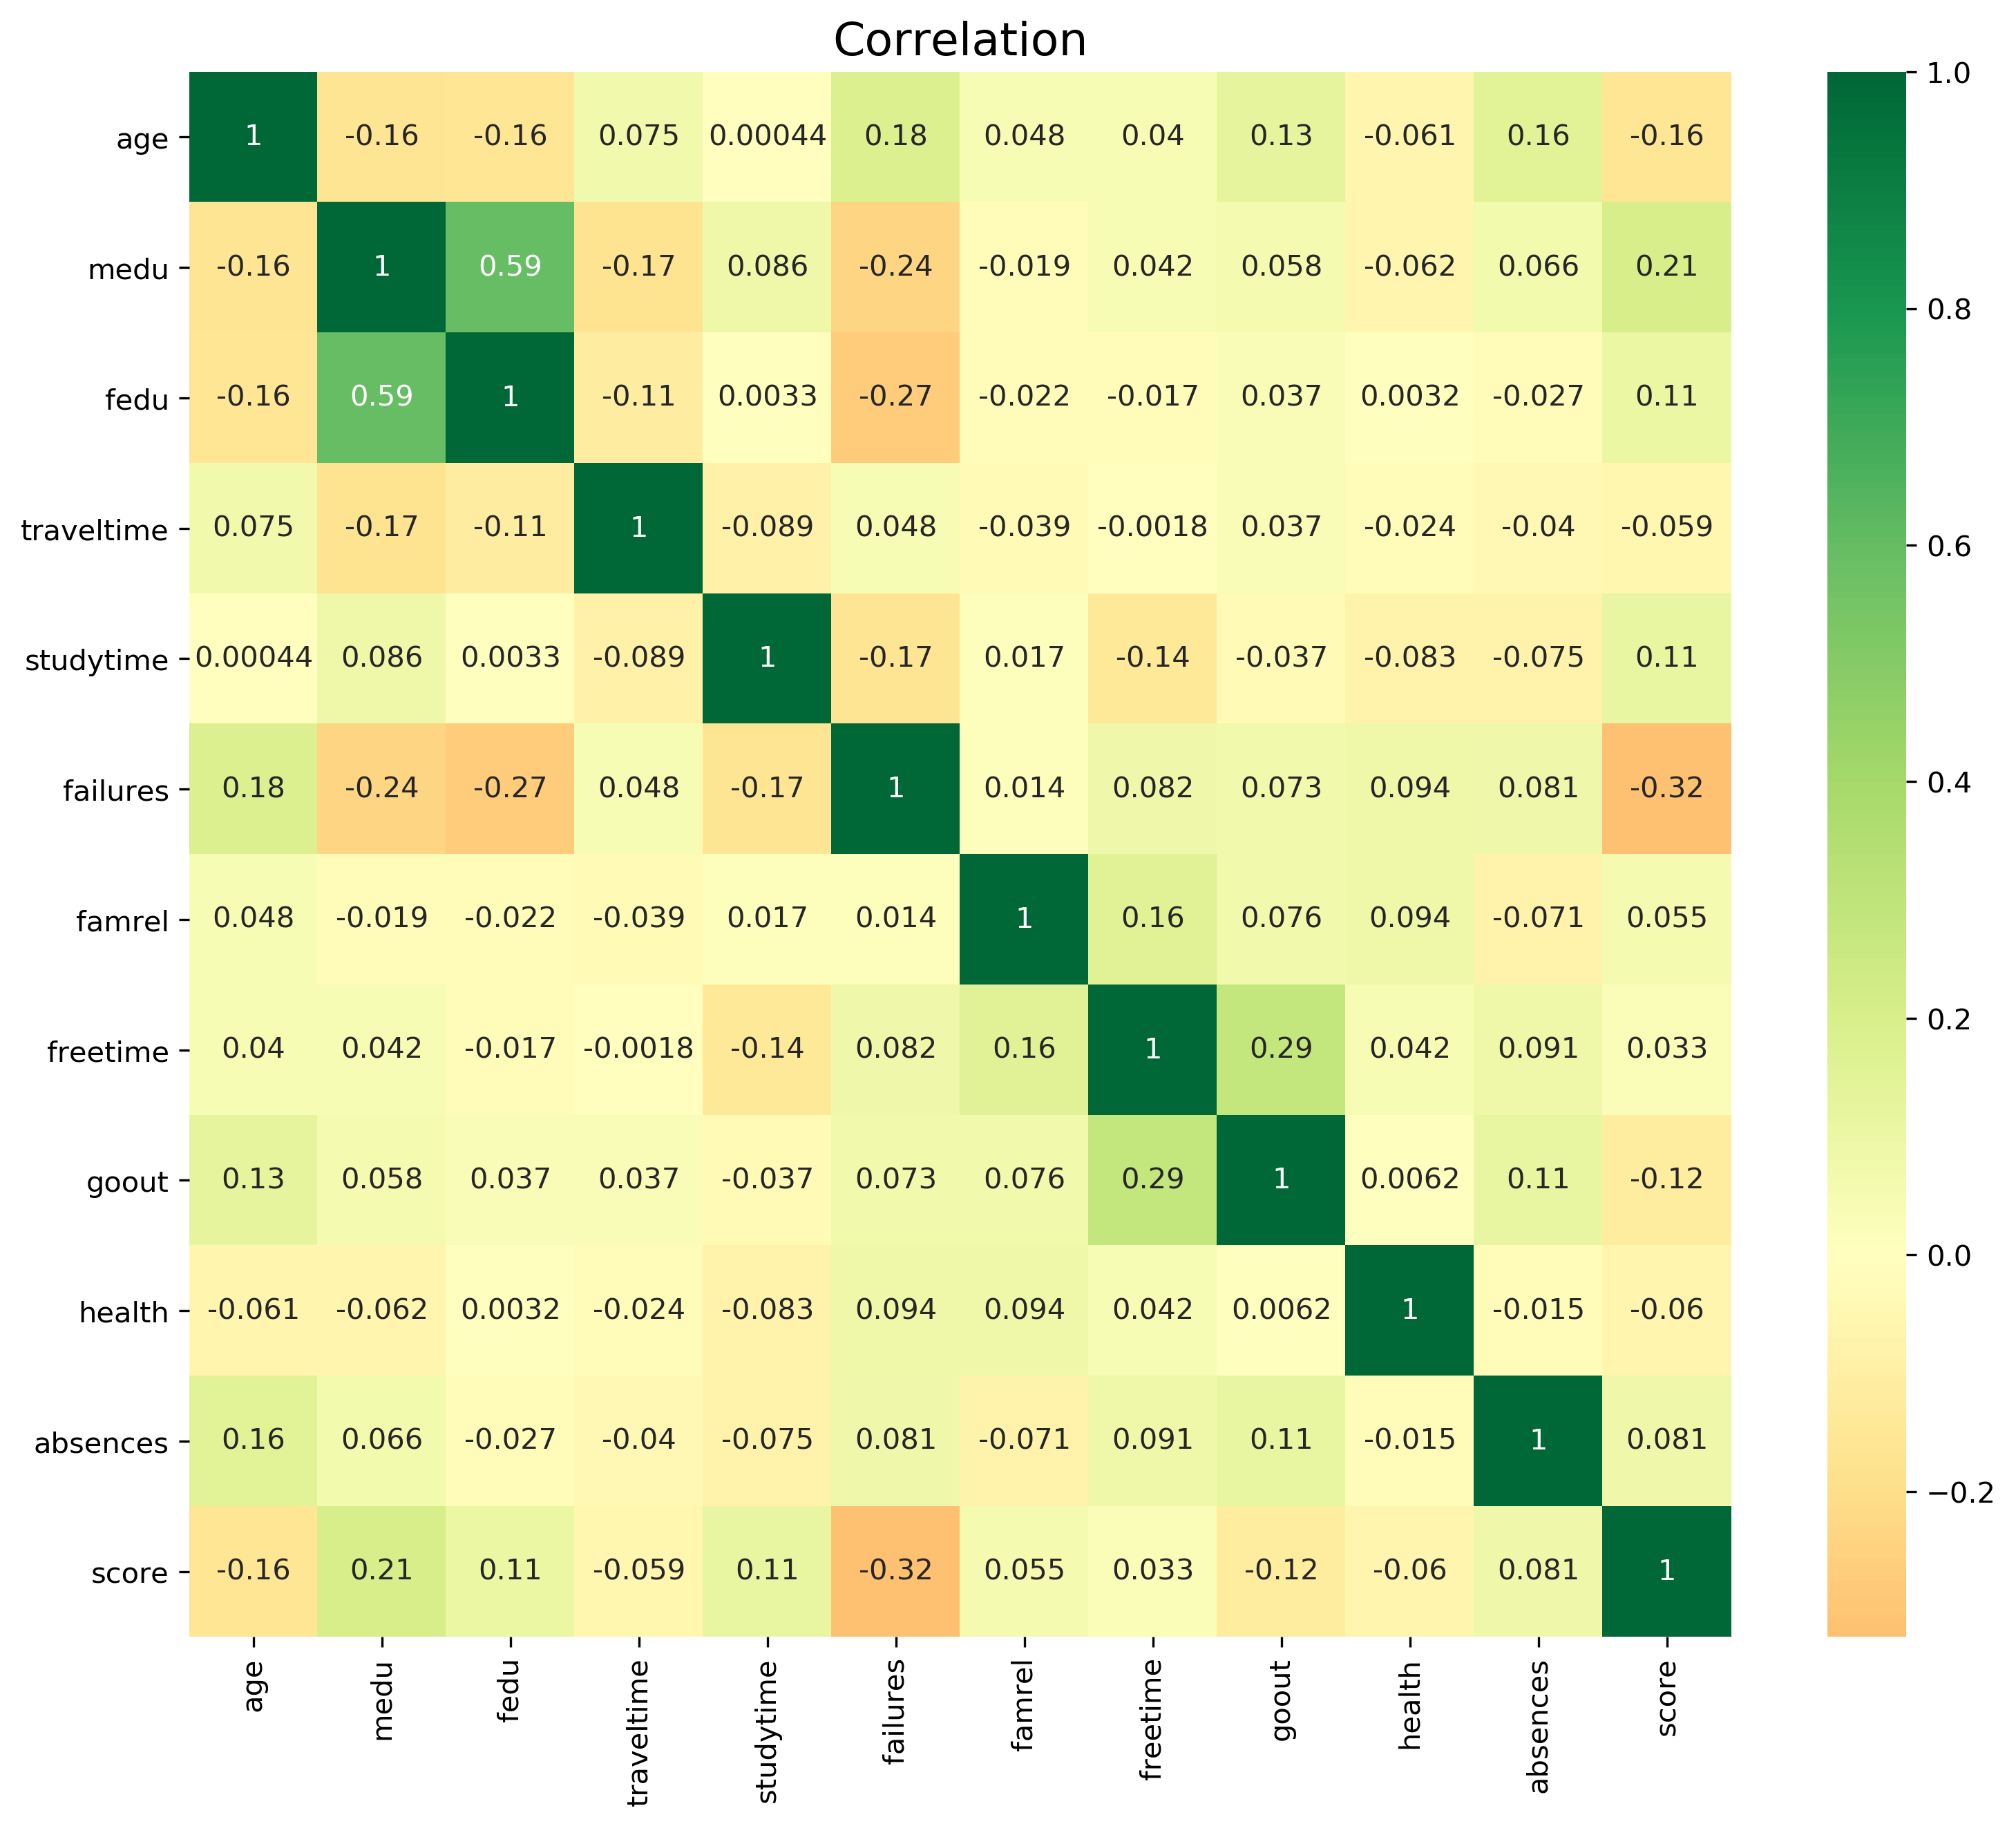

In [122]:
get_corr(df)

No correlated dependencies were found.
Interesting observations:  
    1) Positive correlation on final grade and absences  
    2) The higher the education of the parents, the higher the final score

### Analysis of nominative variables

In [123]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

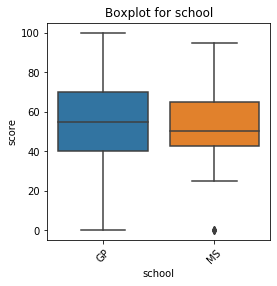

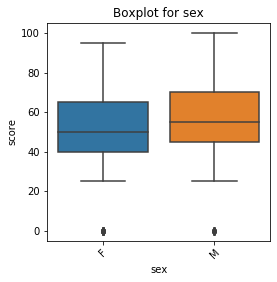

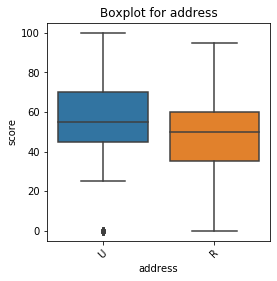

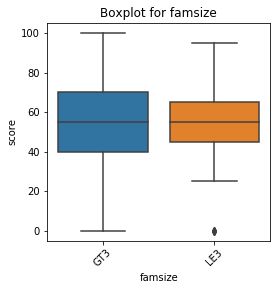

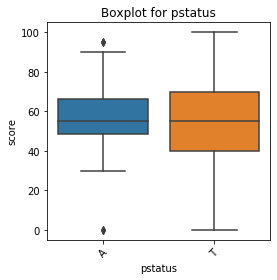

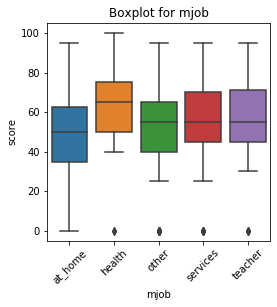

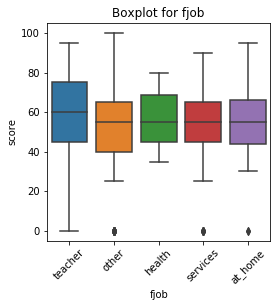

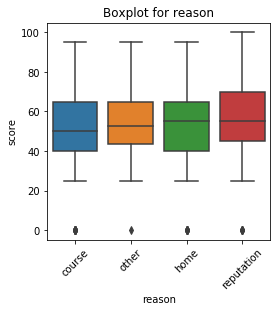

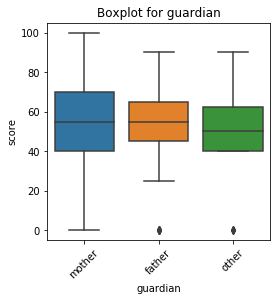

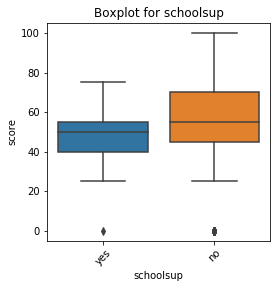

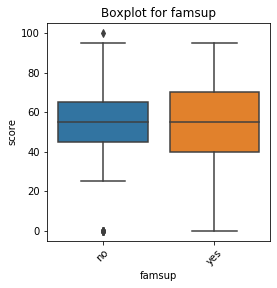

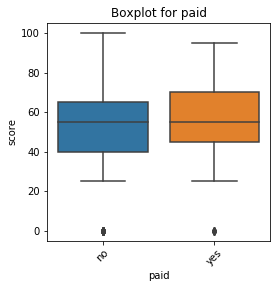

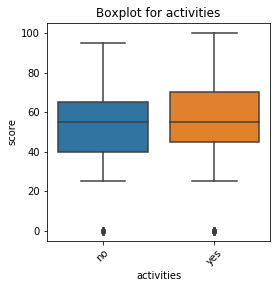

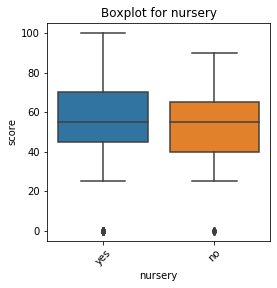

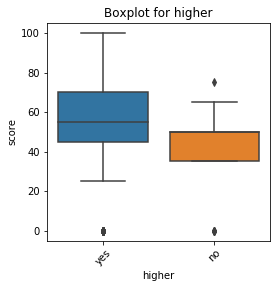

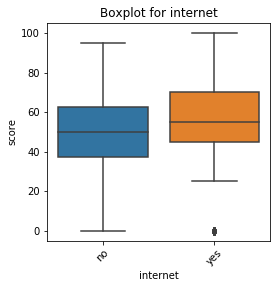

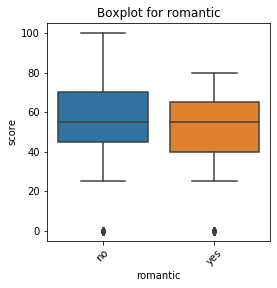

In [124]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob',
            'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
            'nursery', 'higher', 'internet', 'romantic']:
    get_boxplot(col)

From the graphs, it can be assumed that the following data does not affect the final score:  
1)reason  
2)activities  
3)nursery

### Student's t test

In [125]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob',
            'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
            'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(df, col)

Found statistically differences for the column: sex
Found statistically differences for the column: address
Found statistically differences for the column: mjob
Found statistically differences for the column: paid
Found statistically differences for the column: higher
Found statistically differences for the column: romantic


Received significant parameters for the final score

## Preparing data for the model

Create a dataframe for the model

In [126]:
df_for_model = df.loc[:, ['sex', 'age', 'address', 'medu', 'fedu', 'mjob',
                          'traveltime', 'studytime', 'failures', 'paid',
                          'higher', 'romantic', 'famrel', 'freetime', 'goout',
                          'health', 'absences', 'score']]
df_for_model.head()

,sex,age,address,medu,fedu,mjob,traveltime,studytime,failures,paid,higher,romantic,famrel,freetime,goout,health,absences,score
0,F,18,U,4.0,4.0,at_home,2.0,2.0,0.0,no,yes,no,4.0,3.0,4.0,3.0,6.0,30.0
1,F,17,U,1.0,1.0,at_home,1.0,2.0,0.0,no,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,F,15,U,1.0,1.0,at_home,1.0,2.0,3.0,no,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,F,15,U,4.0,2.0,health,1.0,3.0,0.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,F,16,U,3.0,3.0,other,1.0,2.0,0.0,yes,yes,no,4.0,3.0,2.0,5.0,4.0,50.0


Let's replace all binary values with 1 or 0, for the convenience of working with data

In [127]:
bin_to_num(df_for_model, 'sex', 'F', 'M')
bin_to_num(df_for_model, 'address', 'U', 'R')
bin_to_num(df_for_model, 'paid', 'yes', 'no')
bin_to_num(df_for_model, 'higher', 'yes', 'no')
bin_to_num(df_for_model, 'romantic', 'yes', 'no')

The resulting data for the model:

In [128]:
df_for_model.head()

,sex,age,address,medu,fedu,mjob,traveltime,studytime,failures,paid,higher,romantic,famrel,freetime,goout,health,absences,score
0,1,18,1,4.0,4.0,at_home,2.0,2.0,0.0,0,1,0,4.0,3.0,4.0,3.0,6.0,30.0
1,1,17,1,1.0,1.0,at_home,1.0,2.0,0.0,0,1,0,5.0,3.0,3.0,3.0,4.0,30.0
2,1,15,1,1.0,1.0,at_home,1.0,2.0,3.0,0,1,0,4.0,3.0,2.0,3.0,10.0,50.0
3,1,15,1,4.0,2.0,health,1.0,3.0,0.0,1,1,1,3.0,2.0,2.0,5.0,2.0,75.0
4,1,16,1,3.0,3.0,other,1.0,2.0,0.0,1,1,0,4.0,3.0,2.0,5.0,4.0,50.0


In [129]:
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 394
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         361 non-null    int64  
 1   age         361 non-null    int64  
 2   address     361 non-null    int64  
 3   medu        361 non-null    float64
 4   fedu        361 non-null    float64
 5   mjob        361 non-null    object 
 6   traveltime  361 non-null    float64
 7   studytime   361 non-null    float64
 8   failures    361 non-null    float64
 9   paid        361 non-null    int64  
 10  higher      361 non-null    int64  
 11  romantic    361 non-null    int64  
 12  famrel      361 non-null    float64
 13  freetime    361 non-null    float64
 14  goout       361 non-null    float64
 15  health      361 non-null    float64
 16  absences    361 non-null    float64
 17  score       361 non-null    float64
dtypes: float64(11), int64(6), object(1)
memory usage: 63.6+ KB


## Сonclusions

1) There were few gaps in the data  
2) Outliers were only in the absence data  
3) There is a positive correlation between parental education and total math score  
4) There is a negative correlation with the student's return, this is explained by the fact that the older the student, the less time he spends on learning in general  
5) In general, there were no completely correlated data  
6) Nominative analysis showed the following data to be important: *sex, address, mjob, paid, higher, romantic*.  
7) As a result, the following data was selected for training the model: *sex, age, address, medu, fedu, mjob, traveltime, studytime, failures, paid, higher, romantic, famrel, freetime, goout, health, absences, score*